<a href="https://colab.research.google.com/github/mary2121-day/Estif/blob/main/Cleaned_GitHub%F0%9F%8C%BF_Herbal_Leaves_ML_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 Herbal Leaves ML Project
***Using Deep Learning (MobileNetV2) & Grad-CAM for Botanical Identification***

This is my Herbal Leaves Project. The goal was to create a lightweight AI system that identifies 10 medicinal plant species from photos. Grad-CAM is used to visualize what the model “looks at” when making predictions.

***📖 Project Story***

Medicinal plant identification is difficult without expert knowledge. This project aims to build a reliable, interpretable AI model using MobileNetV2 for transfer learning. ***Grad-CAM*** allows visualization of the model’s decision-making.

***🛠️ Tech Stack***

  .Python 3.12

  .TensorFlow / Keras

  .Model: MobileNetV2 (Transfer Learning)

  .Explainable AI: Grad-CAM

# ======================
# 0 — IMPORT LIBRARIES
# ======================

In [ ]:
# -*- coding: utf-8 -*-
"""GitHub-ready Herbal Leaves ML Workflow"""

# --------------------------------------------------------------
# 🌿 Medicinal Herbal Leaf Classification
# Using Deep Learning and Grad-CAM for Botanical Identification
# --------------------------------------------------------------


# This project identifies medicinal plant species from images.
# The model is lightweight, efficient, and uses Grad-CAM for explainability.
# Final model and evaluation results are saved locally in 'results/'.

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


 =====================================================
# 1 — CONSTANTS / HYPERPARAMETERS
 =====================================================

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# ===================
# 2 — DATASET PATH
# ===================


In [ ]:
# Place your dataset in the repo root with this structure:
# Herbal_Leaves/
# ├── train/
# │   ├── species1/
# │   └── ...
# └── val/
#     ├── species1/
#     └── ...

DATASET_PATH = "Herbal_Leaves"

# ================
# 3 — LOAD DATA
# ================

In [ ]:

train_files = glob.glob(os.path.join(DATASET_PATH, 'train/**/*.[jJ][pP][gG]'), recursive=True)
val_files = glob.glob(os.path.join(DATASET_PATH, 'val/**/*.[jJ][pP][gG]'), recursive=True)

# 3. Create DataFrames
if len(train_files) == 0:
    print(f"❌ ERROR: No images found in {DATASET_PATH}. Please check your path!")
else:
    train_df = pd.DataFrame({
        'image_path': train_files,
        'label': [os.path.basename(os.path.dirname(f)) for f in train_files],
        'set': 'train'
    })

    val_df = pd.DataFrame({
        'image_path': val_files,
        'label': [os.path.basename(os.path.dirname(f)) for f in val_files],
        'set': 'val'
    })

    # Combine for Exploration
    df = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)

    print(f"✅ Data Loaded from: {DATASET_PATH}")
    print(f"📊 Total Images: {len(df)}")
    print(f"🌿 Species Found: {df['label'].unique()}")

✅ Data Loaded from: Herbal Leaves
📊 Total Images: 3460
🌿 Species Found: ['Belimbing Wuluh' 'Jambu biji' 'Jeruk' 'Seledri' 'Lidah buaya' 'Pepaya'
 'Kemangi' 'Pandan' 'Nangka' 'Sirih']


# ==========================
# 4 — CLEAN CORRUPT IMAGES
# ==========================

In [ ]:
# 4.1 Remove corrupt file
data_dir = DATASET_PATH
exts = ('.jpg', '.jpeg', '.png')

print(f"🧹 Starting Data Clean-up in: {data_dir}")
corrupt_count = 0

if not os.path.exists(data_dir):
    print(f"❌ Error: {data_dir} does not exist. Run the shortcut/mount cell first!")
else:
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(exts):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print(f'🗑️ Removing corrupt file: {file_path}')
                    os.remove(file_path)
                    corrupt_count += 1

    print(f"✅ Clean-up complete. {corrupt_count} corrupt files removed!")

🧹 Starting Data Clean-up in: Herbal Leaves
✅ Clean-up complete. 0 corrupt files removed!


# =====================================
# 5 — DATA SPLIT (Train / Val / Test)
# =====================================

In [ ]:

train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['label'],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.117,
    stratify=train_val_df['label'],
    random_state=42
)

print(f"✅ 75/10/15 Split Complete:")
print(f"📊 Training (75%):   {len(train_df)}")
print(f"📊 Validation (10%): {len(val_df)}")
print(f"📊 Testing (15%):    {len(test_df)}")

✅ 75/10/15 Split Complete:
📊 Training (75%):   2596
📊 Validation (10%): 345
📊 Testing (15%):    519


# =====================
# 6 — DATA GENERATORS
# =====================

In [ ]:

# Define settings
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True
)

# Train Generator
train_generator = datagen.flow_from_dataframe(
    train_df, x_col='image_path', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='sparse'
)

# Validation Generator (Used during model.fit)
val_generator = datagen.flow_from_dataframe(
    val_df, x_col='image_path', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='sparse', shuffle=False
)

# Test Generator (Used for the final ROC-AUC and Grad-CAM)
test_generator = datagen.flow_from_dataframe(
    test_df, x_col='image_path', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='sparse', shuffle=False
)

Found 2596 validated image filenames belonging to 10 classes.
Found 345 validated image filenames belonging to 10 classes.
Found 519 validated image filenames belonging to 10 classes.


# 7 — BUILD MODEL (MobileNetV2 Transfer Learning)

In [ ]:


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2), # Prevents memorizing/overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model created and compiled. You can now run model.fit()!")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Model created and compiled. You can now run model.fit()!


# 8 — TRAIN MODEL

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, # Start with 20, EarlyStopping will likely stop it sooner
    callbacks=[early_stop]
)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9992 - loss: 0.0117 - val_accuracy: 0.9826 - val_loss: 0.0699
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9886 - loss: 0.0308 - val_accuracy: 0.9797 - val_loss: 0.0699
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9962 - loss: 0.0149 - val_accuracy: 0.9768 - val_loss: 0.0680
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9896 - loss: 0.0268 - val_accuracy: 0.9710 - val_loss: 0.0972
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9854 - loss: 0.0383 - val_accuracy: 0.9826 - val_loss: 0.0644
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9965 - loss: 0.0117 - val_accuracy: 0.9826 - val_loss: 0.0587
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9797 - val_loss: 0.0753
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9914 - loss: 0.0264 - val_accuracy: 0.9768 - v

# ==============================
# 9 — PREDICTIONS & EVALUATION
# ==============================

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


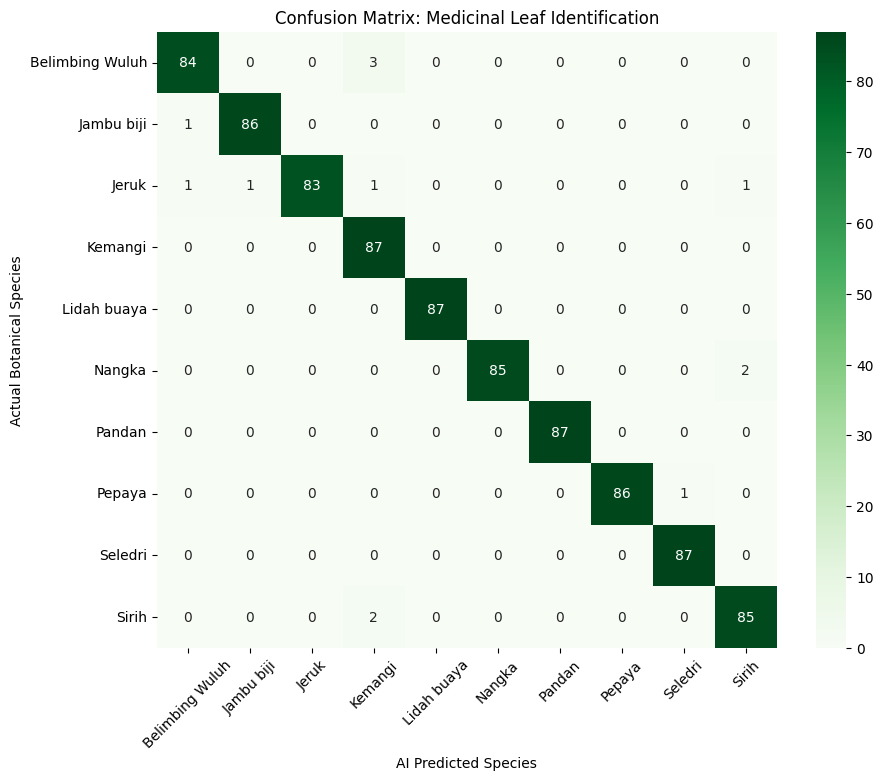


🌿 TECHNICAL PERFORMANCE SUMMARY
✅ Total Correct (TP): 857
❌ Total Missed (FN):  13
⚠️ Total False Alarms (FP): 13
🔄 Optimization Passes: 972 (Forward + Backward)
🛑 Early Stopping: Model stabilized at Epoch 12

--- Detailed Metric Report ---
                 precision    recall  f1-score   support

Belimbing Wuluh       0.98      0.97      0.97        87
     Jambu biji       0.99      0.99      0.99        87
          Jeruk       1.00      0.95      0.98        87
        Kemangi       0.94      1.00      0.97        87
    Lidah buaya       1.00      1.00      1.00        87
         Nangka       1.00      0.98      0.99        87
         Pandan       1.00      1.00      1.00        87
         Pepaya       1.00      0.99      0.99        87
        Seledri       0.99      1.00      0.99        87
          Sirih       0.97      0.98      0.97        87

       accuracy                           0.99       870
      macro avg       0.99      0.99      0.99       870
   weighted avg

In [ ]:

test_generator.reset() # Reset to ensure it starts from the first image
y_pred_classes = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_classes, axis=1)
y_true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 2. Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 3. Plotting the Visual Identity of the Model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', # Using Green for Herbal theme
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Medicinal Leaf Identification')
plt.ylabel('Actual Botanical Species')
plt.xlabel('AI Predicted Species')
plt.xticks(rotation=45)
plt.show()

# 4. --- JOB PORTFOLIO STATISTICS ---
# Extracting True Positives, False Positives, and False Negatives
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP

# Calculation of Training Mechanics
epochs_run = len(history.history['loss'])
# In Keras, each step in an epoch is one Forward/Backward pass
total_passes = epochs_run * len(train_generator)

print(f"\n{'='*40}")
print("🌿 TECHNICAL PERFORMANCE SUMMARY")
print(f"{'='*40}")
print(f"✅ Total Correct (TP): {np.sum(TP)}")
print(f"❌ Total Missed (FN):  {np.sum(FN)}")
print(f"⚠️ Total False Alarms (FP): {np.sum(FP)}")
print(f"🔄 Optimization Passes: {total_passes} (Forward + Backward)")
print(f"🛑 Early Stopping: Model stabilized at Epoch {epochs_run}")
print(f"{'='*40}")

# 5. Detailed Classification Report
print("\n--- Detailed Metric Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# =================
# 10 — SAVE MODEL
# =================

In [ ]:
os.makedirs("results", exist_ok=True)
model.save("results/herbal_leaf_model.h5")
print("✅ Model saved in 'results/herbal_leaf_model.h5'")

# =========================================
# 11 — GRAD-CAM FUNCTION (Explainable AI)
# =========================================



In [ ]:
def get_gradcam_heatmap_final(img_array, model, last_conv_layer_name="out_relu"):

    base_model = model.layers[0]

    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[
            base_model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()

